<a href="https://colab.research.google.com/github/ekolmagorov/StyleTransfer/blob/master/STUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import torch 

from torch.optim import Adam
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import OrderedDict
from torch.utils.tensorboard import SummaryWriter
from google.colab import drive

TODO разобраться с причиной нулевых градиентов - есть подозрение, что копировать тензоры плохая затея поскольку автоматические вызывается .detach()

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon May 24 16:06:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
random.seed(123)

DEVICE  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

4/1AY0e-g5NK5WsDAYsKgpSmzdSWB2ZEAyHPG5Vwo9U7oLE0-Wrg19cnzv13zc4/1AY0e-g5NK5WsDAYsKgpSmzdSWB2ZEAyHPG5Vwo9U7oLE0-Wrg19cnzv13zc

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
% cd /content/drive/MyDrive/курсовая
#! ls

/content/drive/MyDrive/курсовая


In [6]:
#! unzip style.zip

In [7]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [8]:
'''
resnet = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True)
length = len(list(resnet.children()))
od = OrderedDict()
for index, (name, val) in enumerate(resnet.named_children()):
  if index == length - 2:
    break
  od[name] = val

od

resnet = nn.Sequential(od)
'''

"\nresnet = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True)\nlength = len(list(resnet.children()))\nod = OrderedDict()\nfor index, (name, val) in enumerate(resnet.named_children()):\n  if index == length - 2:\n    break\n  od[name] = val\n\nod\n\nresnet = nn.Sequential(od)\n"

In [9]:
vgg = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True).features

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [10]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [11]:
len(vgg)

31

In [12]:
example_tensor = torch.randn((1, 3, 256, 256))
out = vgg(example_tensor)
out.shape

torch.Size([1, 512, 8, 8])

In [13]:
hasattr(vgg, '6')
getattr(vgg, '6')

ReLU(inplace=True)

In [14]:
class EncoderBlock(nn.Module):

    '''
    Encoder part in Unet-style neural network model
    '''

    def __get_activation(self, name):
        def __hook(module, input, output):
            self.output[name] = output

        return __hook


    def __init__(self, encoder_model, output_layers=None, requires_grad=True):
      super(EncoderBlock, self).__init__()

      self.model = encoder_model
      for param in self.model.parameters():
        param.requires_grad = requires_grad
        
      self.output_layers = output_layers
      self.output = {}

      if output_layers is not None:
        
        for idx, layer_name in enumerate(output_layers):

          if not hasattr(self.model, layer_name):
            raise KeyError("such {} in your encoder model doesn't exist".
                           format(layer_name))

          getattr(self.model, layer_name).register_forward_hook(
              self.__get_activation(layer_name)
              )


    def forward(self, x):

      self.output.clear()
      out = self.model(x)
      self.output['out'] = out
      return out, self.output.copy()

In [15]:
LAYERS_NAME = ['1', '6', '11', '18', '25']
encoder = EncoderBlock(vgg, LAYERS_NAME)

In [16]:
example_tensor = torch.randn((2, 3, 256, 256))
out, d_out = encoder(example_tensor)

In [17]:
print(d_out['1'].shape)

torch.Size([2, 64, 256, 256])


In [18]:
#print(out, )

In [19]:
#TODO add weights to signal after adain transformation

class AdainBlock(nn.Module):

    def __init__(self, layers_names):
        super(AdainBlock, self).__init__()
        self.layers_names = layers_names
        self.outputs = {}

    def transform(self, content, style):
        content_size, style_size = content.size(), style.size()
        content_sigma = torch.std(content, dim=(2, 3), keepdims=True).expand(content_size)
        style_sigma = torch.std(style, dim=(2, 3), keepdims=True).expand(style_size)

        content_mu = torch.mean(content, dim=(2, 3), keepdims=True).expand(content_size)
        style_mu = torch.mean(style, dim=(2, 3), keepdims=True).expand(style_size)

        
        out = style_sigma * ((content - content_mu)/ (content_sigma + 1e-5)) + style_mu

        return  out

    def forward(self, content_features, style_features):

        self.outputs.clear()

        for layer_name in self.layers_names:

            self.outputs[layer_name] = self.transform(
                                              content_features[layer_name],
                                              style_features[layer_name])
            
        return self.outputs.copy()


In [20]:
example_tensor_c = torch.randn((1, 3, 256, 256))
example_tensor_s = torch.randn((1, 3, 256, 256))

adain = AdainBlock(LAYERS_NAME + ['out'])

out_c, d_out_c = encoder(example_tensor_c)
out_s, d_out_s = encoder(example_tensor_s)

outputs = adain(d_out_c, d_out_s)
for name, value in outputs.items():
    print("name: {}, shape: {}".format(name, value.shape))

name: 1, shape: torch.Size([1, 64, 256, 256])
name: 6, shape: torch.Size([1, 128, 128, 128])
name: 11, shape: torch.Size([1, 256, 64, 64])
name: 18, shape: torch.Size([1, 512, 32, 32])
name: 25, shape: torch.Size([1, 512, 16, 16])
name: out, shape: torch.Size([1, 512, 8, 8])


In [21]:
#print(outputs)

In [22]:
'''
out_height, out_width = out.shape[-2:]
skip_height, skip_width = skip_feature.shape[-2:]

out_height_pad = out_height - max(out_height, skip_height)
out_width_pad = out_width - max(out_width, skip_width)

skip_height_pad = skip_height - max(out_height, skip_height)
skip_width_pad = skip_width - max(out_width, skip_width)

out = nn.ZeroPad2d((out_height_pad, 0, out_width_pad))(out)
skip_feature = nn.ZeroPad2d((skip_height_pad, 0, skip_width_pad))(skip_feature)
d'''

'\nout_height, out_width = out.shape[-2:]\nskip_height, skip_width = skip_feature.shape[-2:]\n\nout_height_pad = out_height - max(out_height, skip_height)\nout_width_pad = out_width - max(out_width, skip_width)\n\nskip_height_pad = skip_height - max(out_height, skip_height)\nskip_width_pad = skip_width - max(out_width, skip_width)\n\nout = nn.ZeroPad2d((out_height_pad, 0, out_width_pad))(out)\nskip_feature = nn.ZeroPad2d((skip_height_pad, 0, skip_width_pad))(skip_feature)\nd'

In [23]:
def crop_tensors(first, second):
    first_height, first_width = first.shape[-2:]
    second_height, second_width = second.shape[-2:]

    min_height = min(first_height, second_height)
    min_width = min(first_width, second_width)

    first = first[:, :, :min_height, :min_width]
    second = second[:, :, :min_height, :min_width]

    return first, second


class DecoderBlock(nn.Module):
  
    def createDecoderBlock(self, in_channels, out_channels, kernel_size=3,
                           stride=1, scale_factor=2):
        decoder_block = nn.Sequential(OrderedDict([
             
            ('upsample', nn.Upsample(scale_factor=scale_factor)),
            ('conv1', nn.Conv2d(in_channels,
                                out_channels,
                                kernel_size=kernel_size,
                                stride=stride,
                                padding=1)),
            ]))
        
        return decoder_block

    def createFusionBlock(self, in_channels, out_channels, kernel_size=3, stride=1):
        fusion_block =  nn.Sequential(nn.Conv2d(in_channels,
                                                 out_channels,
                                                 kernel_size=kernel_size,
                                                 stride=1,
                                                 padding=1),
                                       nn.ReLU())
        
        return fusion_block


    def __init__(self, channels_sizes):

        super(DecoderBlock, self).__init__()
        self.decoder_channels = channels_sizes
        
        self.decoder_layers = nn.ModuleList(
            [self.createDecoderBlock(c_size_in, c_size_out) 
            for (c_size_in, c_size_out) in channels_sizes])
        
        
        self.fusion_layers = nn.ModuleList(
            [self.createFusionBlock(2*c_size_out, c_size_out) 
            for (c_size_in, c_size_out) in channels_sizes])
        
        self.last_decoder_layer = self.createDecoderBlock(channels_sizes[-1][-1], 3, scale_factor=1)

        self.last_layer_act = nn.ReLU()#nn.Sigmoid()

    def forward(self, out, skip_features):

        skip_features = skip_features[::-1]


        for idx, skip_feature in enumerate(skip_features):

          
            out = nn.ReLU()(self.decoder_layers[idx](out))
            out, skip_feature = crop_tensors(out, skip_feature)
            #print(out.shape, skip_feature.shape)
            out = self.fusion_layers[idx](torch.cat((out, skip_feature), dim=1))
            #out = skip_feature + out
        out = self.last_decoder_layer(out)

        return nn.Sigmoid()(out)

In [24]:
CHANNELS_SIZES = [(512, 512),
                  (512, 512),
                  (512, 256),
                  (256, 128),
                  (128, 64)]

decoder = DecoderBlock(CHANNELS_SIZES)

channels_orders = {
    0: '1',
    1: '6',
    2: '11',
    3: '18',
    4: '25'}

skip_features = [outputs[channels_orders[i]]
                 for i in range(len(channels_orders))]

x = decoder(outputs['out'], skip_features)
x.shape

torch.Size([1, 3, 256, 256])

In [25]:
class STUNet(nn.Module):

    def __init__(self, encoder_block, adain_block, decoder_block,
                 skip_layers, features_sizes):

          super(STUNet, self).__init__()
          self.encoder_model = EncoderBlock(encoder_block, skip_layers, requires_grad=True)
          self.adain_model = AdainBlock(skip_layers)
          self.decoder_model = DecoderBlock(features_sizes)

          #self.weights = nn.ParameterList([nn.Parameter(torch.ones(1, requires_grad=False), requires_grad=False)
          #                                 for i in range(len(skip_layers) + 1)])
          self.weights = [ 1 for i in range(len(skip_layers) + 1) ]
          self.dropout = nn.Dropout(p=0.5)
    def forward(self, content_images, style_images):

        enc_out_c, enc_d_out_c = self.encoder_model(content_images)
        enc_out_s, enc_d_out_s = self.encoder_model(style_images)
        #print(enc_d_out_c, enc_d_out_s)
        adain_out  = adain.transform(enc_out_c, enc_out_s) 
        adain_outs = adain(enc_d_out_c, enc_d_out_s)

        skip_features = [self.weights[i] * self.dropout(adain_outs[channels_orders[i]])
                 for i in range(len(channels_orders))]

        adain_out = self.dropout(adain_out) * self.weights[-1]

        out = self.decoder_model(adain_out, skip_features)

        return out
    
    '''
    def to(self, device):
        super().to(device)
        for weight in self.weights:
            weight = weight.to(device)
        return self
    '''

In [26]:
#resnet = nn.Sequential(od)
adain = AdainBlock(LAYERS_NAME)
decoder = DecoderBlock(CHANNELS_SIZES)


main_model = STUNet(vgg, adain, decoder, LAYERS_NAME, CHANNELS_SIZES)

In [27]:
example_tensor_c = torch.randn((1, 3, 512, 512))
example_tensor_s = torch.randn((1, 3, 512, 512))

x = main_model(example_tensor_c, example_tensor_s)

In [28]:
x.shape

torch.Size([1, 3, 512, 512])

In [29]:
from skimage.io import imread

class STDataSet(Dataset):

    def __init__(self, content_filenames, style_filenames, get_random=True, **kwargs):
        self.style_filenames = style_filenames
        self.content_filenames = content_filenames

        self.get_random = get_random
        self.kwargs = kwargs
      
        if not self.get_random:
            l_style = len(self.style_filenames)
            l_content = len(self.content_filenames)

            styles_filenames = [
                                     self.style_filenames[i]
                                     for i in range(len(self.style_filenames))
                                     for j in range(len(self.content_filenames))
                                    ]

            content_filenames = [
                                      self.content_filename[j]
                                      for i in range(self.style_filenames)
                                      for j in range(self.content_filenames)
                                      ]

            self.train_set = zip(content_filenames, styles_filenames)
        

    def __len__(self):
      return len(self.style_filenames) * len(self.content_filenames)
    
    def __getitem__(self, idx):
      if torch.is_tensor(idx):
            idx = idx.tolist()
    
      if self.get_random:
          content_filename = self.content_filenames[
                                random.randint(0, len(self.content_filenames)-1)
                                ]

          style_filename = self.style_filenames[
                                random.randint(0, len(self.style_filenames)-1)
                                ]
         
      else:
          content_filename, style_filename = self.train_set[idx]

      content, style = Image.open(content_filename), Image.open(style_filename)

      if 'content_transform' in self.kwargs:
          content = self.kwargs['content_transform'](content)
      
      if 'style_transform' in self.kwargs:
          style = self.kwargs['style_transform'](style)
      #print(style.shape)
      return (content, style)

In [30]:
contents_dir_train = 'target_dataset/Contents'
styles_dir_train = 'target_dataset/Styles'



content_filenames_train = [os.path.join(contents_dir_train, filename)
                          for filename in os.listdir(contents_dir_train)]

style_filenames_train = [os.path.join(styles_dir_train, filename) 
                        for filename in  os.listdir(styles_dir_train)]

In [31]:
#-------------------------------------------------------------------------------
contents_dir_test = 'target_dataset/articles_contents'
styles_dir_test = 'target_dataset/articles_styles'
#-------------------------------------------------------------------------------


content_filenames_test = [os.path.join(contents_dir_test, filename)
                          for filename in os.listdir(contents_dir_test)]

style_filenames_test = [os.path.join(styles_dir_test, filename) 
                        for filename in  os.listdir(styles_dir_test)]

In [32]:
transform = transforms.Compose([transforms.Resize((512, 512)),
                                      transforms.ToTensor()])

dataset_train = STDataSet(content_filenames_train,
                          style_filenames_train,
                          style_transform=transform,
                          content_transform=transform)

dataset_test = STDataSet(content_filenames_test,
                         style_filenames_test,
                         style_transform=transform,
                         content_transform=transform)



content, style = dataset_train[1]

#fig, axes = plt.subplots(1,2, figsize=(15, 15))
#axes[0].imshow(content)
#axes[1].imshow(style)

In [33]:
class TransformerLoss(EncoderBlock):

    def __init__(self, encoder_model, output_layers=None, weights=None, requires_grad=False):
        if weights is not None:
            assert len(output_layers) == len(weights)

        self.weights = weights

        super(TransformerLoss, self).__init__(encoder_model, output_layers)

        for param in self.model.parameters():
            param.requires_grad = requires_grad


    @staticmethod
    def compute_gram_matrix_loss(first_tensor, second_tensor):

        n, c, h, w = first_tensor.shape
        first_tensor = first_tensor.view(n, c, -1)
        second_tensor = second_tensor.view(n, c, -1)

        G1 = torch.bmm(first_tensor, first_tensor.transpose(2, 1))
        G2 = torch.bmm(second_tensor, second_tensor.transpose(2, 1))

        loss = torch.sum((G1 - G2) ** 2) / ((2 * n * c) ** 2)

        return loss


    @staticmethod
    def compute_style_loss(first_tensor, second_tensor):
        first_tensor_mean = torch.mean(first_tensor, dim=(-1, -2))
        second_tensor_mean = torch.mean(second_tensor, dim=(-1, -2))

        mu_diff = torch.mean(torch.sqrt(
            torch.sum((first_tensor_mean - second_tensor_mean) ** 2, dim=-1)
            ))

        first_tensor_std = torch.std(first_tensor, dim=(-1, -2))
        second_tensor_std = torch.std(second_tensor, dim=(-1, -2))

        std_diff = torch.mean(torch.sqrt(
            torch.sum((first_tensor_std - second_tensor_std) ** 2, dim=-1)
            ))


        total_diff = mu_diff + std_diff
 
        return total_diff

    @staticmethod
    def compute_content_loss(first_tensor, second_tensor):

        tensor_diff = torch.mean(torch.sqrt(
              torch.sum((first_tensor - second_tensor) ** 2, dim=(1,2,3))
              ))
        #tensor_diff = torch.sqrt(nn.MSELoss(first_tensor, second_tensor, reduction='sum')

        return tensor_diff


    def __compute_loss(self, enc_first, enc_second, func):
        assert enc_first.keys() == enc_second.keys()


        loss = 0
        for key in self.output_layers:
            
            first_tensor, second_tensor = enc_first[key], enc_second[key]

            l = func(first_tensor, second_tensor)

            loss +=  l * self.weights[key] if self.weights[key] is not None else l
        return loss
            
            

    def __call__(self, content, style, out):

        content, out = crop_tensors(content, out)
        enc_content, enc_content_d = EncoderBlock.__call__(self, content)
        #print(enc_content_d)
        enc_style, enc_style_d = EncoderBlock.__call__(self, style)
        #print(enc_style_d)
        enc_out, enc_out_d = EncoderBlock.__call__(self, out)
        
        c_loss = self.__compute_loss(enc_out_d,
                                     enc_content_d,
                                     self.compute_content_loss)
        
        s_loss = self.__compute_loss(enc_out_d,
                                     enc_style_d,
                                     self.compute_style_loss)

        return c_loss, s_loss

In [34]:
vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [35]:
#layers = ['6', '11', '18', '25']
weights = { '6': 1,
           '11': 1,
           '18': 1,
           '25': 1}

layers = weights.keys()
loss_model = TransformerLoss(vgg19.features, layers, weights, False).eval()


content_example = torch.zeros(1, 3, 512, 512)
style_example = torch.ones(1, 3, 256, 256)
out_example = (torch.ones(1, 3, 512, 512) / 2)

c_loss, s_loss = loss_model(content_example,
                                       style_example,
                                       out_example)

print("C_loss : {}, s_loss: {}".format(c_loss.item(), s_loss.item()))

C_loss : 738.6434326171875, s_loss: 17.83333969116211


In [36]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import Line2D

def plot_grad_flow_v2(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    #plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [37]:
def normalize(tensor):
    mu = torch.Tensor([ [ [[0.485]], [[0.456]], [[0.406]] ] ]).to(DEVICE)

    std =  torch.Tensor([ [ [[0.229]], [[0.224]], [[0.225]] ] ]).to(DEVICE)

    return (tensor - mu) /std

In [38]:
import time
count_num_params = lambda model: sum(p.numel() for p in model.parameters()
                                    if p.requires_grad)



def get_cuda_mem_info():
    t = torch.cuda.get_device_properties(0).total_memory / 1e9
    r = torch.cuda.memory_reserved(0) /1e9
    a = torch.cuda.memory_allocated(0) / 1e9

    return t, r, a

def train(model, optimizer, dataset, loss_fn, num_steps, batch_size=1, lr=1e-3, alpha=1, out_frequency=None):

    print("Start:{},{}, {}".format(*get_cuda_mem_info()))
    model.train()
    model = model.to(DEVICE)
    #print("After model:{},{}, {}".format(*get_cuda_mem_info()))
    loss_fn = loss_fn.eval().to(DEVICE)
    #print("After loss:{},{}, {}".format(*get_cuda_mem_info()))
    num_params = count_num_params(model)
    print("Train model with: {} parameters".format(num_params))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    optimizer_base = optimizer(model.parameters(), lr=lr)
    #optimizer_weights = optimizer(model.weights, lr=1e-2)
    writer = SummaryWriter()
    #writer.add_graph(model)


    dataloader_size = len(dataloader)
    

    #normalize = nn.Sequential(transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                             std=[0.229, 0.224, 0.225]))
    c_loss, s_loss, total_loss = 0, 0, 0
    num_iters = 0
    while num_iters < num_steps:
      for idx, (contents, styles) in enumerate(dataloader):
          #print(num_iters)
          if num_iters > num_steps:
              break
          n_channels, style_height, style_width = styles.shape[-3:]
          #if style_height > 800 or style_width > 800 or n_channels < 3:
          #  continue


          contents, styles = contents.to(DEVICE), styles.to(DEVICE)
          contents, styles = normalize(contents), normalize(styles)

          optimizer_base.zero_grad()
          #optimizer_weights.zero_grad()

          out_img = model(contents, styles)

          content_loss, style_loss = loss_fn(contents,
                                             styles,
                                             normalize(out_img)
          )


          #loss =  #nn.MSELoss()(out_img[:, :, :200, :200],contents[:, :, :200, :200])
          loss = style_loss + alpha * content_loss
         # hooks = register_hooks(loss)
          c_loss += content_loss.item()
          s_loss += style_loss.item()
          total_loss += loss.item()
          loss.backward()

          
          optimizer_base.step()
          #optimizer_weights.step()

          num_iters += 1
         


          if (out_frequency) and not (num_iters % out_frequency):
              #for n, p in model.named_parameters():
              #  print(n)
              #  print(n, p.grad.max(), p.grad.min())
              #print([p.data.item() for p in model.weights])
              plot_grad_flow_v2(model.named_parameters())
              plt.show()
              #get_hooks = hooks()
              #return get_hooks
              window_loss = total_loss / out_frequency
              c_loss = c_loss /out_frequency
              s_loss = s_loss / out_frequency

              print("Iter: {} | Train loss on last  {} : total - {}, content-{}, style-{}".format(num_iters,
                                                                    out_frequency,
                                                                    window_loss,
                                                                    c_loss, s_loss
                                                                    ))
              total_loss, c_loss, s_loss = 0, 0, 0

    return model

Start:16.945512448,0.0, 0.0
Train model with: 31971715 parameters


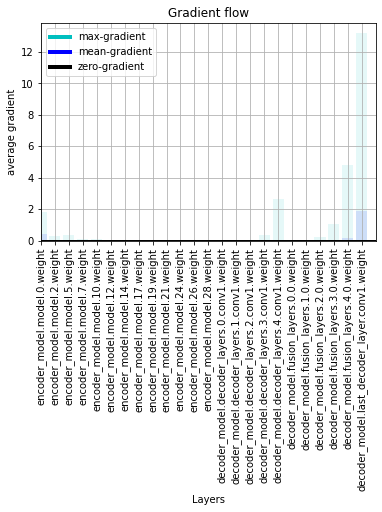

Iter: 10 | Train loss on last  10 : total - 177.16268920898438, content-15112.91708984375, style-131.82393951416014


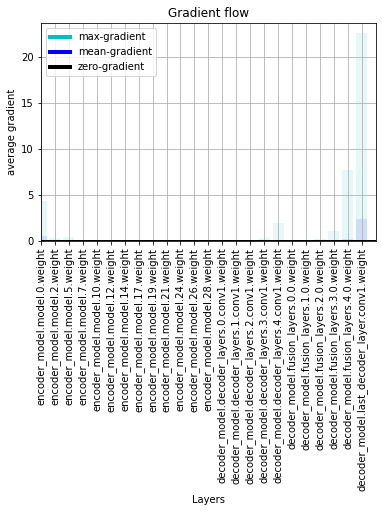

Iter: 20 | Train loss on last  10 : total - 179.2719268798828, content-14338.98046875, style-136.2549835205078


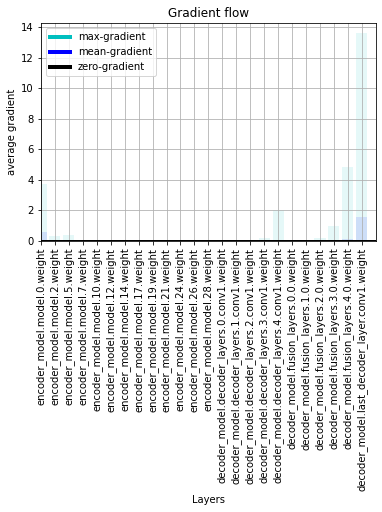

Iter: 30 | Train loss on last  10 : total - 166.75734252929686, content-13322.32880859375, style-126.7903564453125


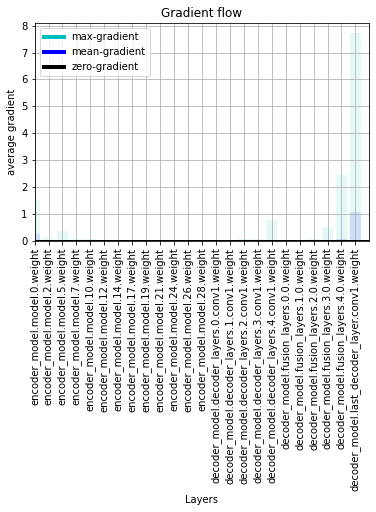

Iter: 40 | Train loss on last  10 : total - 167.65671005249024, content-12889.4564453125, style-128.98834075927735


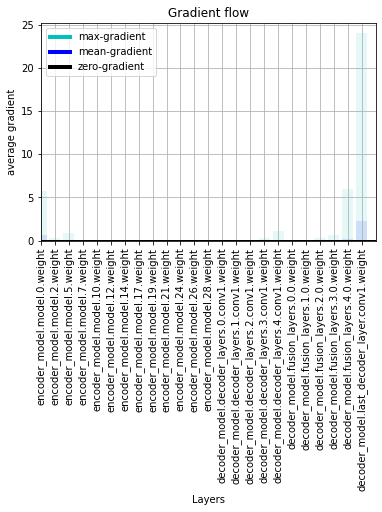

Iter: 50 | Train loss on last  10 : total - 157.3446823120117, content-12277.77587890625, style-120.51135711669922


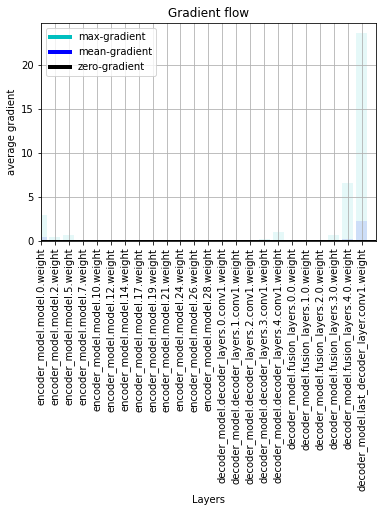

Iter: 60 | Train loss on last  10 : total - 166.8984161376953, content-12759.04765625, style-128.62127304077148


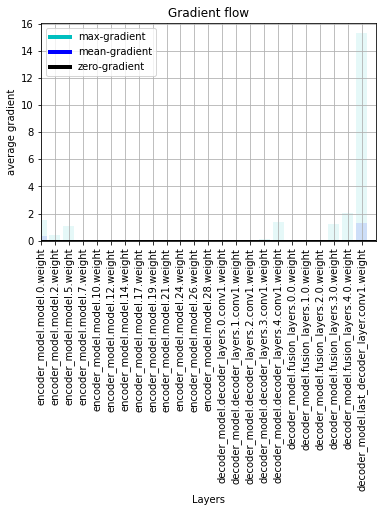

Iter: 70 | Train loss on last  10 : total - 165.3609390258789, content-12693.20830078125, style-127.28131484985352


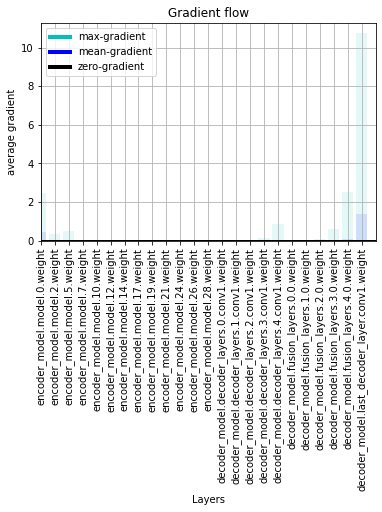

Iter: 80 | Train loss on last  10 : total - 160.96107864379883, content-13100.9587890625, style-121.65820236206055


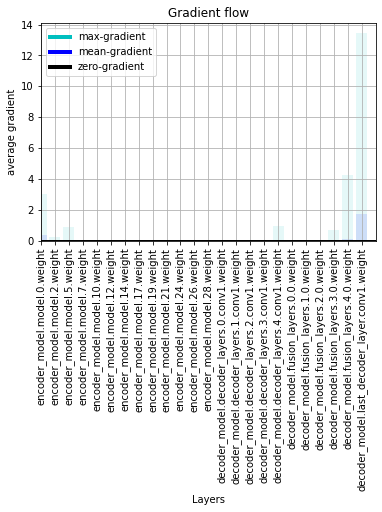

Iter: 90 | Train loss on last  10 : total - 182.71194229125976, content-12852.21142578125, style-144.1553092956543


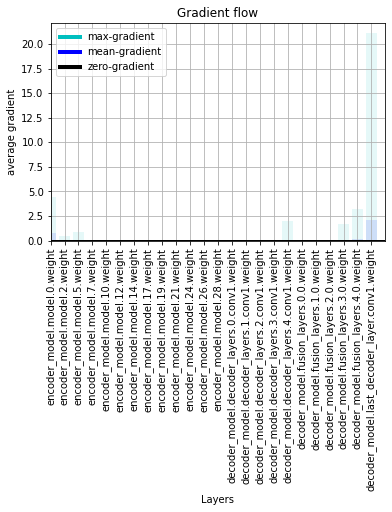

Iter: 100 | Train loss on last  10 : total - 155.04792404174805, content-12660.1666015625, style-117.06742324829102


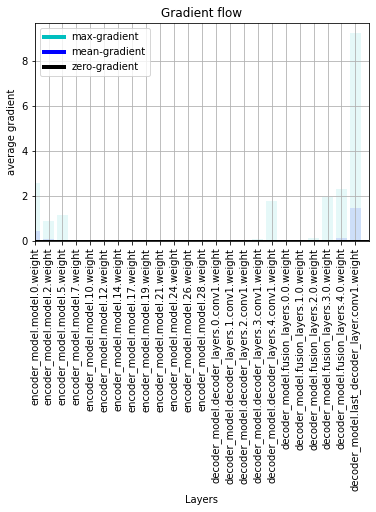

Iter: 110 | Train loss on last  10 : total - 154.83196716308595, content-12375.69150390625, style-117.7048942565918


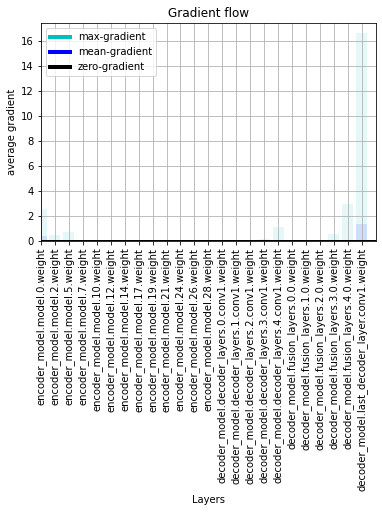

Iter: 120 | Train loss on last  10 : total - 181.91314392089845, content-13858.9427734375, style-140.3363166809082


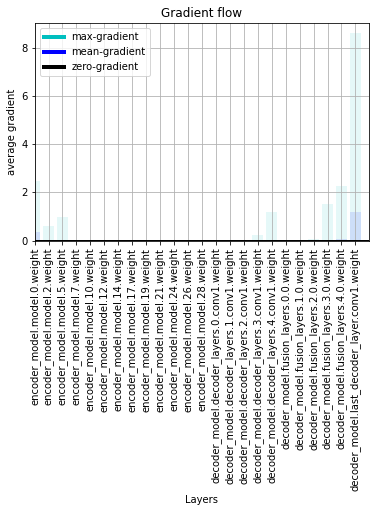

Iter: 130 | Train loss on last  10 : total - 165.86202545166014, content-12569.19111328125, style-128.15445251464843


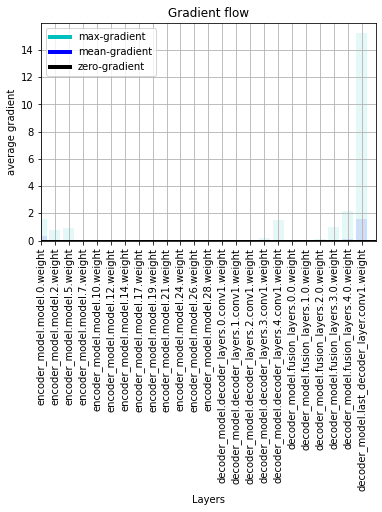

Iter: 140 | Train loss on last  10 : total - 175.05465698242188, content-13261.73173828125, style-135.26946029663085


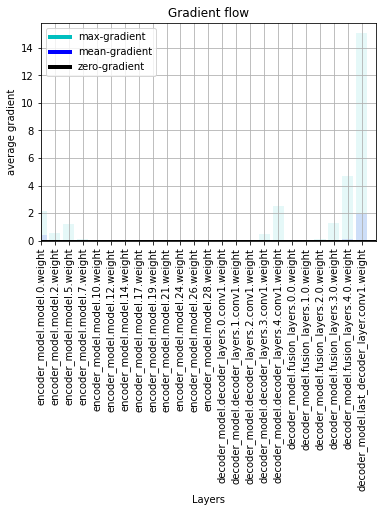

Iter: 150 | Train loss on last  10 : total - 161.18502807617188, content-13025.2001953125, style-122.10942993164062


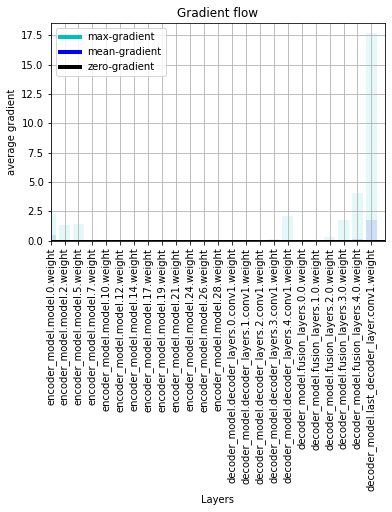

Iter: 160 | Train loss on last  10 : total - 166.41708221435547, content-13188.5123046875, style-126.85154418945312


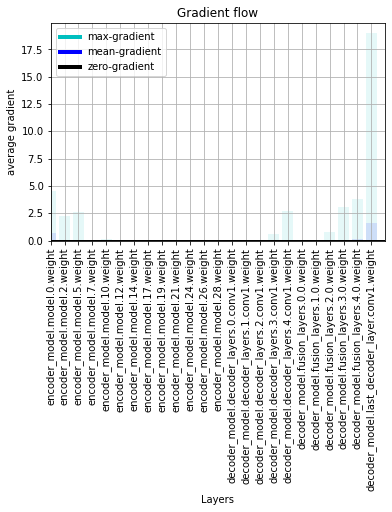

Iter: 170 | Train loss on last  10 : total - 153.67792892456055, content-13557.41279296875, style-113.00569000244141


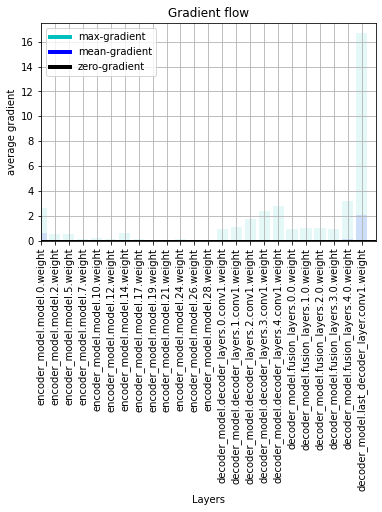

Iter: 180 | Train loss on last  10 : total - 164.81657028198242, content-13513.31279296875, style-124.27663192749023


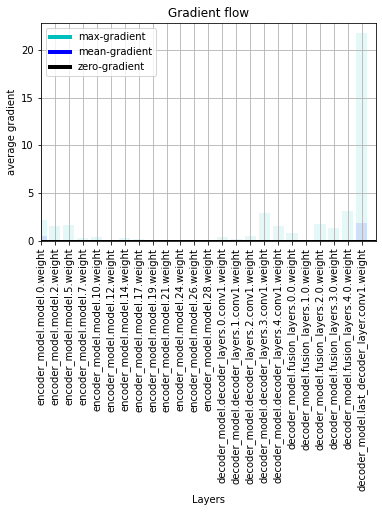

Iter: 190 | Train loss on last  10 : total - 159.49689178466798, content-13389.5091796875, style-119.32836151123047


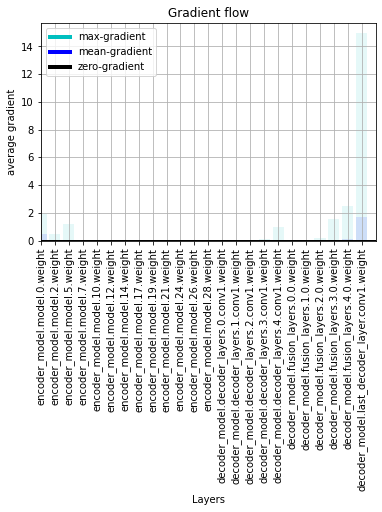

Iter: 200 | Train loss on last  10 : total - 158.12127227783202, content-14093.854296875, style-115.83971099853515


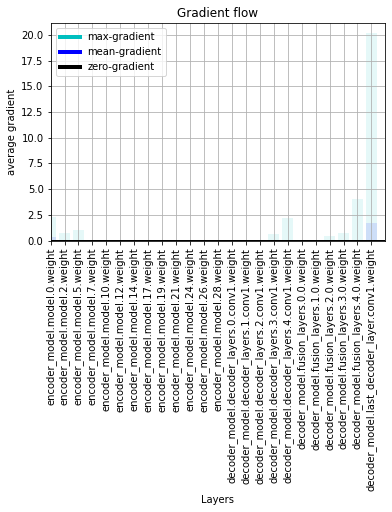

Iter: 210 | Train loss on last  10 : total - 152.27467193603516, content-13327.20302734375, style-112.29306030273438


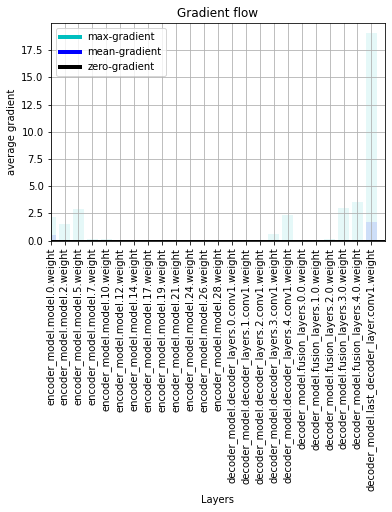

Iter: 220 | Train loss on last  10 : total - 141.85296401977538, content-13455.43251953125, style-101.48666458129883


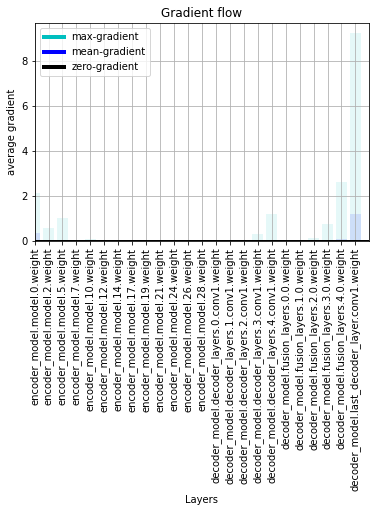

Iter: 230 | Train loss on last  10 : total - 160.59156341552733, content-14199.5875, style-117.99279861450195


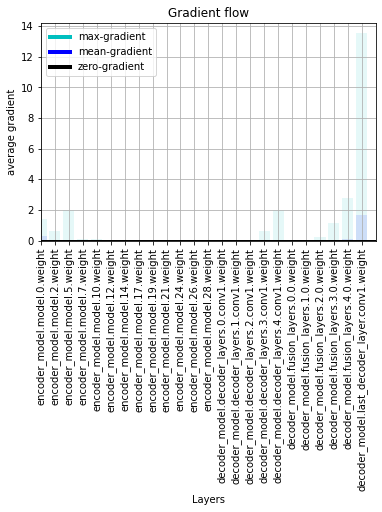

Iter: 240 | Train loss on last  10 : total - 140.70829315185546, content-13591.65458984375, style-99.93333053588867


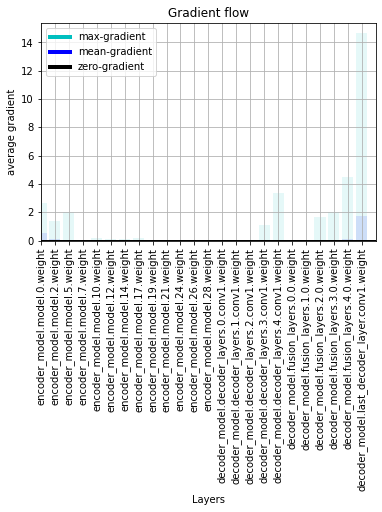

Iter: 250 | Train loss on last  10 : total - 152.48958587646484, content-14653.173828125, style-108.53006286621094


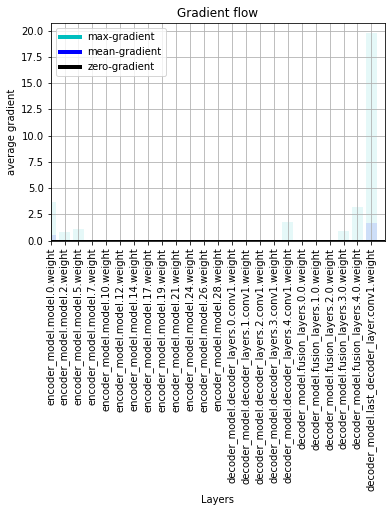

Iter: 260 | Train loss on last  10 : total - 164.66478729248047, content-14298.73310546875, style-121.76858901977539


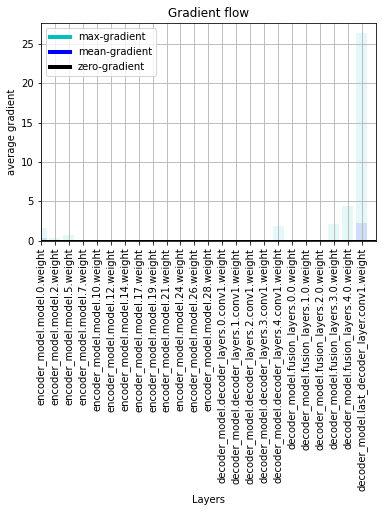

Iter: 270 | Train loss on last  10 : total - 169.46506958007814, content-14022.88251953125, style-127.39642181396485


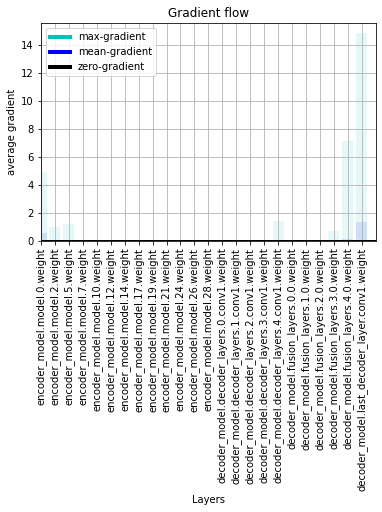

Iter: 280 | Train loss on last  10 : total - 167.60012969970703, content-14479.1091796875, style-124.16280364990234


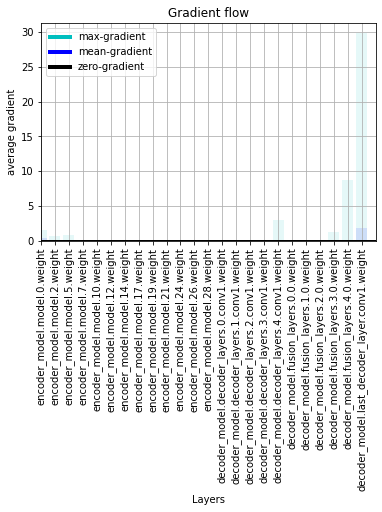

Iter: 290 | Train loss on last  10 : total - 151.4317367553711, content-15061.38642578125, style-106.24757537841796


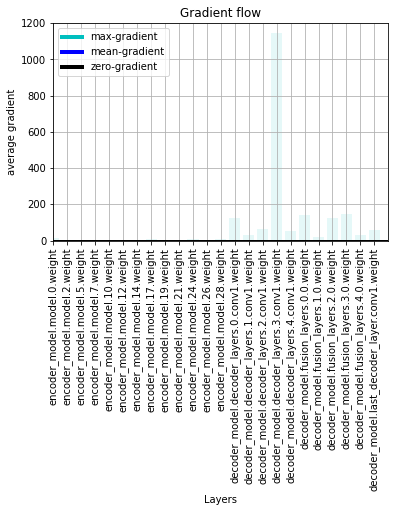

Iter: 300 | Train loss on last  10 : total - 155.63465270996093, content-15315.23955078125, style-109.68893356323242


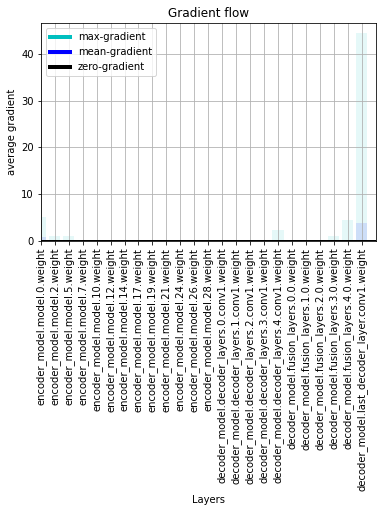

Iter: 310 | Train loss on last  10 : total - 157.87461700439454, content-15177.6125, style-112.34177932739257


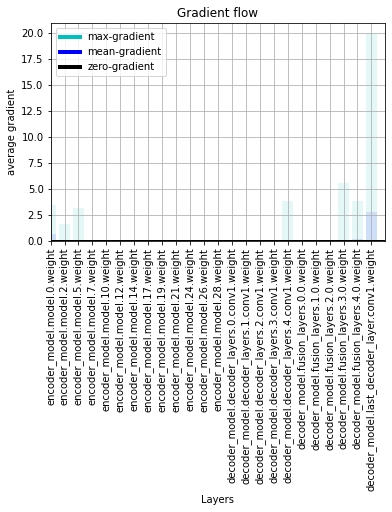

Iter: 320 | Train loss on last  10 : total - 159.53834075927733, content-14198.02587890625, style-116.9442642211914


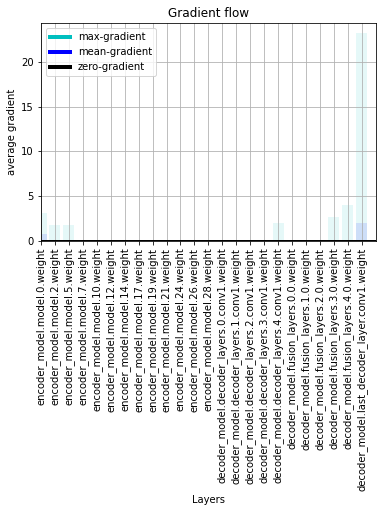

Iter: 330 | Train loss on last  10 : total - 162.0515884399414, content-13988.85068359375, style-120.08503646850586


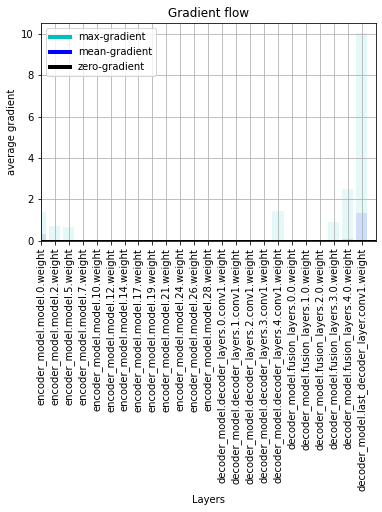

Iter: 340 | Train loss on last  10 : total - 146.91431121826173, content-14637.1828125, style-103.00276031494141


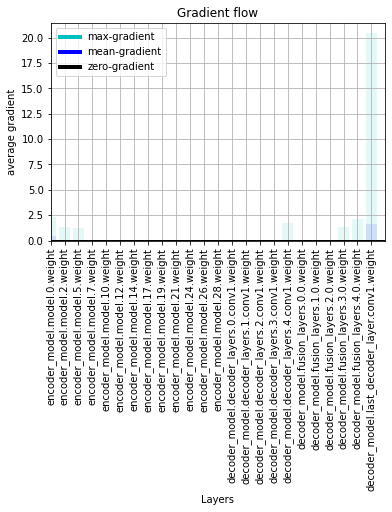

Iter: 350 | Train loss on last  10 : total - 142.26548538208007, content-14728.66044921875, style-98.07950286865234


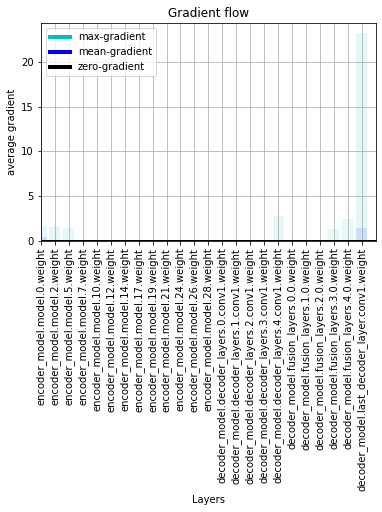

Iter: 360 | Train loss on last  10 : total - 148.56764602661133, content-14702.15732421875, style-104.4611717224121


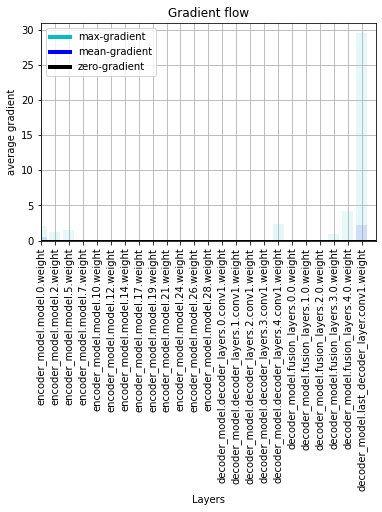

Iter: 370 | Train loss on last  10 : total - 151.69470672607423, content-15591.92705078125, style-104.9189239501953


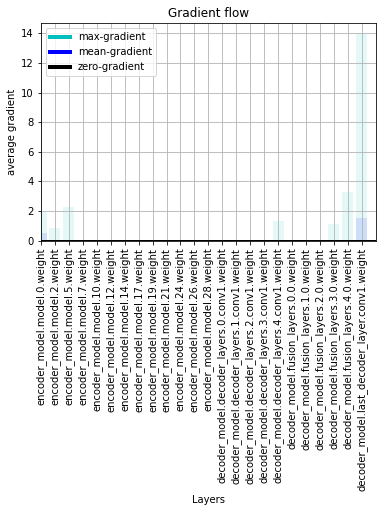

Iter: 380 | Train loss on last  10 : total - 147.90088500976563, content-14905.5841796875, style-103.18413009643555


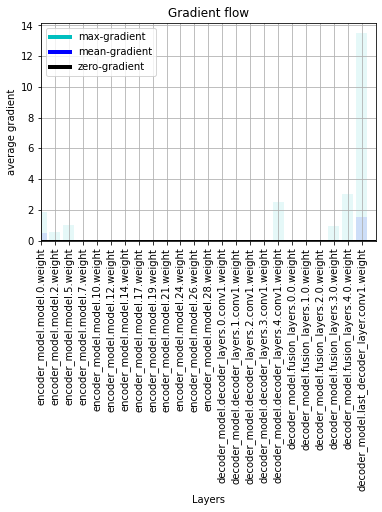

Iter: 390 | Train loss on last  10 : total - 140.03604736328126, content-14350.012109375, style-96.98601264953614


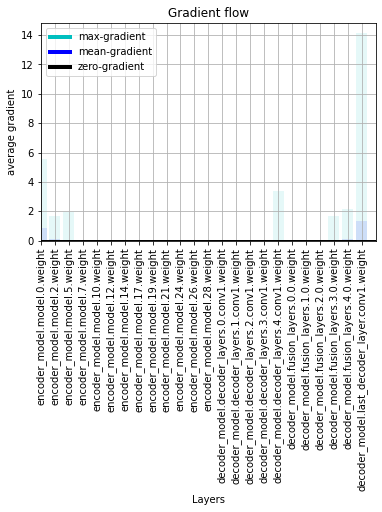

Iter: 400 | Train loss on last  10 : total - 142.37004623413085, content-14493.32734375, style-98.89006271362305


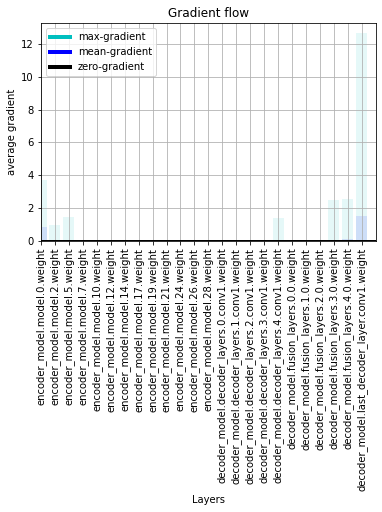

Iter: 410 | Train loss on last  10 : total - 143.86551666259766, content-14220.4736328125, style-101.20409393310547


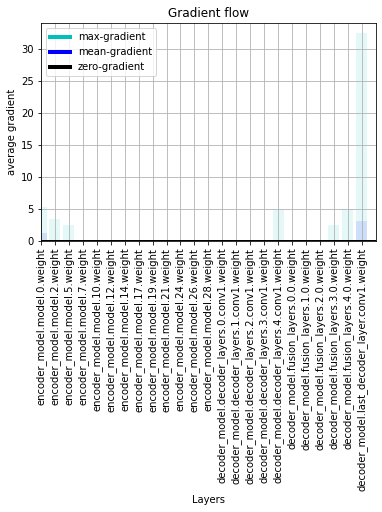

Iter: 420 | Train loss on last  10 : total - 149.24025650024413, content-15091.653125, style-103.96529617309571


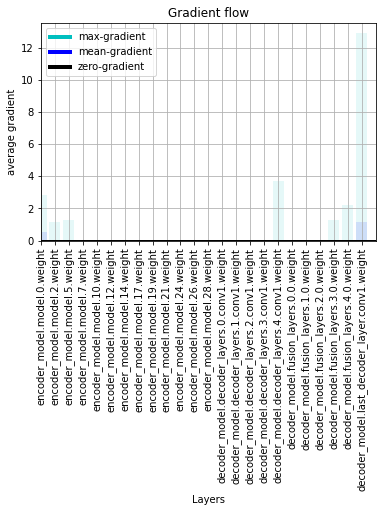

Iter: 430 | Train loss on last  10 : total - 158.56956329345704, content-16121.98603515625, style-110.20360794067383


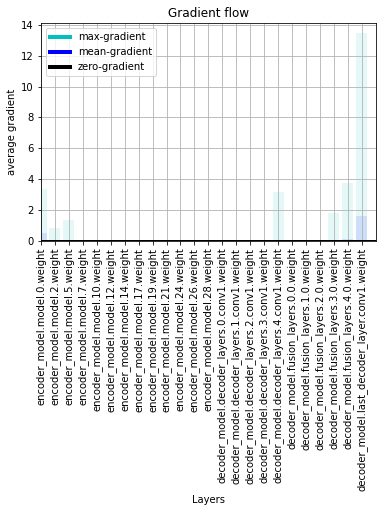

Iter: 440 | Train loss on last  10 : total - 148.26324157714845, content-15136.51845703125, style-102.8536865234375


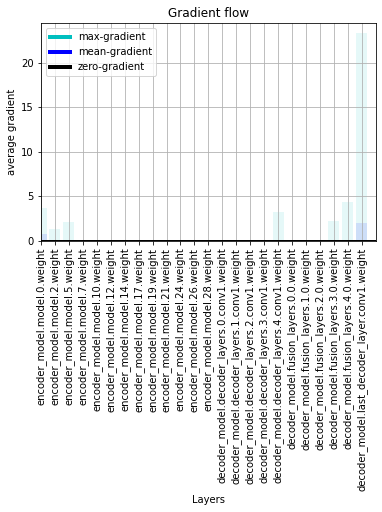

Iter: 450 | Train loss on last  10 : total - 141.60686492919922, content-14784.94521484375, style-97.25202941894531


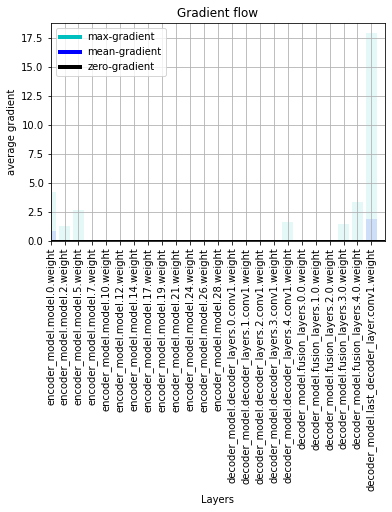

Iter: 460 | Train loss on last  10 : total - 139.2412452697754, content-14549.96025390625, style-95.59136276245117


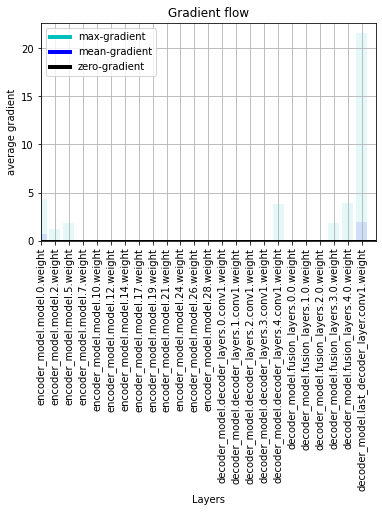

Iter: 470 | Train loss on last  10 : total - 140.89375762939454, content-15338.38310546875, style-94.87860717773438


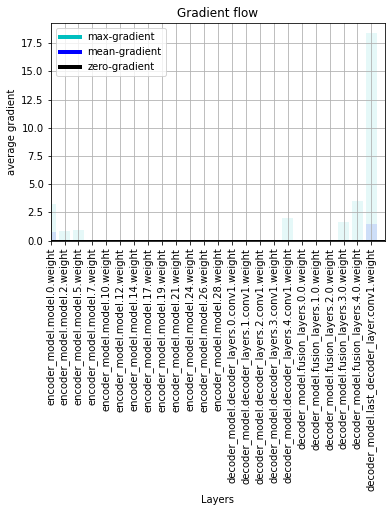

Iter: 480 | Train loss on last  10 : total - 146.97838821411133, content-15558.51396484375, style-100.3028465270996


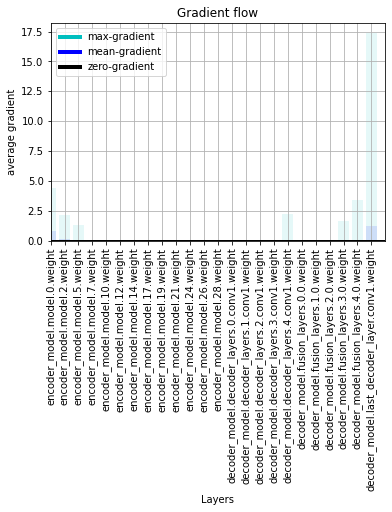

Iter: 490 | Train loss on last  10 : total - 147.2085273742676, content-14957.6916015625, style-102.33545150756837


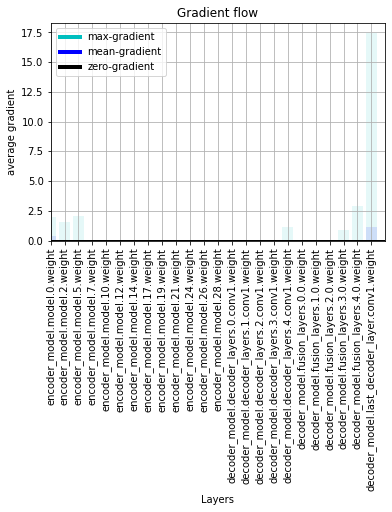

Iter: 500 | Train loss on last  10 : total - 139.3738784790039, content-15499.44443359375, style-92.87554397583008


In [39]:
main_model = train(main_model,
                  Adam,
                  dataset_train,
                  loss_model,
                  500,
                  batch_size=3,
                  lr=1e-3,
                  out_frequency=10,
                  alpha=3e-3)

In [40]:
#main_model

In [41]:
#list(main_model.named_parameters())

In [42]:
#list(main_model.weights.named_parameters())

In [43]:
#w = [torch.clone(w.data) for w in main_model.weights]
#w

In [44]:
#main_model.weights[1].data = torch.zeros(1).to(DEVICE)
#main_model.weights[0].data

In [45]:
main_model = main_model.eval()

In [46]:
name = 'unet_model.pth'
torch.save(main_model.state_dict(), name)

In [47]:
#resnet = nn.Sequential(od)
##adain = AdainBlock(LAYERS_NAME)
#decoder = DecoderBlock(CHANNELS_SIZES)


#main_model = STUNet(vgg, adain, decoder, LAYERS_NAME, CHANNELS_SIZES)

In [48]:
#main_model.load_state_dict(torch.load(name))
#main_model = main_model.to(DEVICE)

In [49]:
#main_model


In [67]:
torch.cuda.empty_cache()
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])


#contents, styles = dataset_train[4]
contents_t, styles_t = torch.unsqueeze(contents, 0).to(DEVICE), torch.unsqueeze(styles, 0).to(DEVICE)
main_model.weights = [0, 1, 1, 1, 1, 1]
out_img = main_model(normalize(contents_t), normalize(styles_t))[0]
print(out_img.shape, contents.shape)
pil_img = transforms.ToPILImage()(out_img.detach())



torch.Size([3, 512, 512]) torch.Size([3, 512, 512])


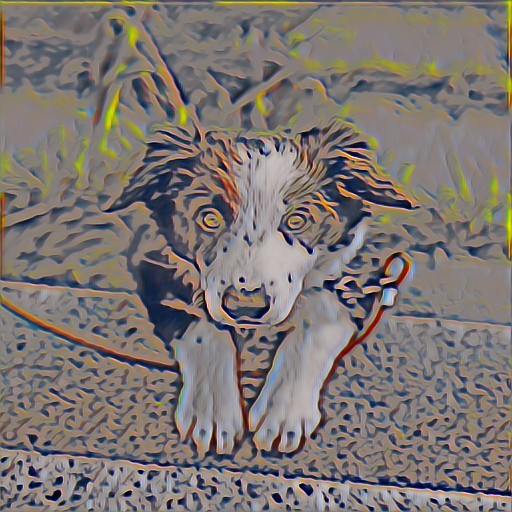

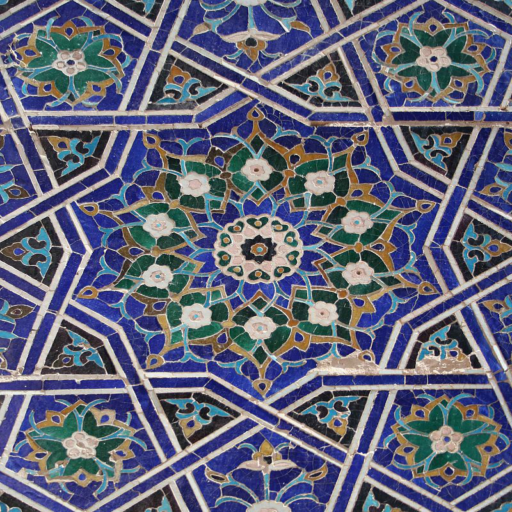

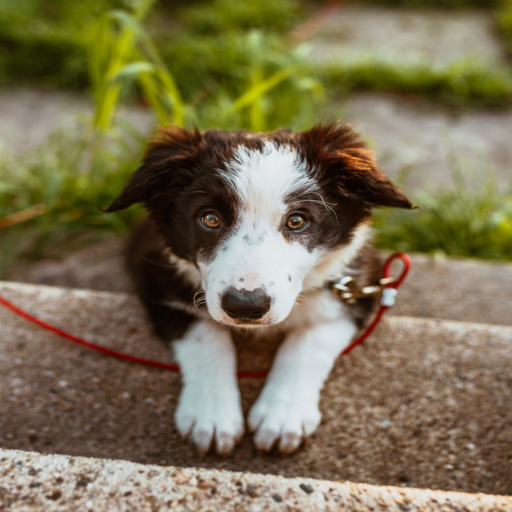

In [68]:
from IPython.display import display # to display images
display(pil_img)
display(transforms.ToPILImage()(styles))
display(transforms.ToPILImage()(contents))

In [52]:
t = torch.Tensor([[1, 2], [3, 4]])
print(torch.mean(t, (1), keepdims=True))

tensor([[1.5000],
        [3.5000]])


In [53]:
p = nn.Parameter(torch.randn(1))

In [54]:
p.data.item()

-0.06641844660043716

In [55]:
a = torch.randn(2, 54, 224, 224)
a = a.view(2, 54, -1)

In [56]:
a.shape

torch.Size([2, 54, 50176])

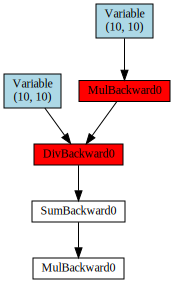

In [57]:
from graphviz import Digraph
import torch
from torch.autograd import Variable, Function

def iter_graph(root, callback):
    queue = [root]
    seen = set()
    while queue:
        fn = queue.pop()
        if fn in seen:
            continue
        seen.add(fn)
        for next_fn, _ in fn.next_functions:
            if next_fn is not None:
                queue.append(next_fn)
        callback(fn)

def register_hooks(var):
    fn_dict = {}
    def hook_cb(fn):
        def register_grad(grad_input, grad_output):
            fn_dict[fn] = grad_input
        fn.register_hook(register_grad)
    iter_graph(var.grad_fn, hook_cb)

    def is_bad_grad(grad_output):
        if grad_output is None:
            return False
        return grad_output.isnan().any() or (grad_output.abs() >= 1e6).any()

    def make_dot():
        node_attr = dict(style='filled',
                        shape='box',
                        align='left',
                        fontsize='12',
                        ranksep='0.1',
                        height='0.2')
        dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))

        def size_to_str(size):
            return '('+(', ').join(map(str, size))+')'

        def build_graph(fn):
            if hasattr(fn, 'variable'):  # if GradAccumulator
                u = fn.variable
                node_name = 'Variable\n ' + size_to_str(u.size())
                dot.node(str(id(u)), node_name, fillcolor='lightblue')
            else:
                assert fn in fn_dict, fn
                fillcolor = 'white'
                if any(is_bad_grad(gi) for gi in fn_dict[fn]):
                    fillcolor = 'red'
                dot.node(str(id(fn)), str(type(fn).__name__), fillcolor=fillcolor)
            for next_fn, _ in fn.next_functions:
                if next_fn is not None:
                    next_id = id(getattr(next_fn, 'variable', next_fn))
                    dot.edge(str(next_id), str(id(fn)))
        iter_graph(var.grad_fn, build_graph)

        return dot

    return make_dot

x = torch.randn(10, 10, requires_grad=True)
y = torch.randn(10, 10, requires_grad=True)

z = x / (y * 0)
z = z.sum() * 2
get_dot = register_hooks(z)
z.backward()
dot = get_dot()
#dot.save('tmp.dot') # to get .dot
#dot.render('tmp') # to get SVG
dot # in Jupyter, you can just render the variable



In [58]:
a = torch.Tensor([[[1,2],
                  [3, 4]]])
a.shape

torch.Size([1, 2, 2])

In [59]:
a.mean(dim=(-1,-2), keepdims=True)

tensor([[[2.5000]]])

In [60]:
#def fuse_two_nets(net1, net2, alpha):



In [61]:

    #normalize = nn.Sequential(transforms.Normalize(mean=, , ],
    #                             std=[0.229, 0.224, 0.225]))

In [62]:
example = torch.randn(2, 3, 256, 256)

In [63]:
(example - mu ) / std

NameError: ignored